In [1]:
import os
import torch
import sys
import re
import glob
import random
import numpy as np
import pandas as pd
import scanpy as sc
from PIL import Image
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from torch.utils.data import Dataset, DataLoader, random_split
from scipy.spatial.distance import cdist
import torchvision.transforms as T
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import timm
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
import logging
import h5py
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from typing import List, Tuple, Sequence, Dict, Any, Optional
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from scipy.spatial import ConvexHull
import matplotlib.lines as mlines

/home/hongyi/miniconda3/envs/llava/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# read h5 metadata
with h5py.File("/home/hongyi/project/HEST/hest_data/patches/TENX13.h5", "r") as f:
    raw_barcodes = f["barcode"][:]
    coords_all   = f["coords"][:]
    n_total      =f["img"][:].shape[0]

barcodes = [b.decode("utf-8") if isinstance(b, bytes) else b for b in raw_barcodes.flatten()]

# read AnnData & QC
adata = sc.read_h5ad("/home/hongyi/project/HEST/hest_data/st/TENX13.h5ad")
sc.pp.filter_cells(adata, min_genes=1)
sc.pp.filter_genes(adata, min_cells=1)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Only keep valid barcodes and corresponding coordinates
valid_barcodes = [bc for bc in barcodes if bc in adata.obs_names]
adata_sub = adata[valid_barcodes].copy()

matched_indices = [i for i, bc in enumerate(barcodes) if bc in adata_sub.obs_names]
barcodes = [barcodes[i] for i in matched_indices]
coords = coords_all[matched_indices]

# Ensure gene expression is in the same order
barcode_idx = [adata_sub.obs_names.get_loc(bc) for bc in barcodes]
gene_exp = adata_sub.X[barcode_idx].astype(np.float32)
gene_name = adata_sub.var_names
if not isinstance(gene_exp, np.ndarray):
    gene_exp = gene_exp.toarray()

# Select 250 genes by mean expression
gene_means = gene_exp.mean(axis=0)  # shape: (num_genes,)
top_k = 250
top_gene_indices = np.argsort(gene_means)[-top_k:]
gene_exp_top = gene_exp[:, top_gene_indices]  # shape: (num_spots, 250)
gene_names_top = gene_name[top_gene_indices]

# Reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Randomly split datasets
TRAIN_SPLIT  = 0.30
VAL_SPLIT    = 0.20

num_samples = len(gene_exp_top)
indices = np.arange(num_samples)
np.random.seed(SEED)
np.random.shuffle(indices)

train_size = int(num_samples * TRAIN_SPLIT)
val_size = int(num_samples * VAL_SPLIT)
test_size = num_samples - val_size - train_size

train_idx, test_idx = (
    indices[:train_size+val_size],
    indices[train_size+val_size:]
)


In [ ]:
def _ensure_gene_index(gene_names_top, gene) -> int:
    if isinstance(gene, int):
        if gene < 0 or gene >= len(gene_names_top):
            raise IndexError("Gene index out of range.")
        return gene
    idx = {g: i for i, g in enumerate(gene_names_top)}
    if gene not in idx:
        raise ValueError(f"Gene '{gene}' not found.")
    return idx[gene]

def _load_wsi(wsi_path: Optional[str]):
    if wsi_path is None:
        return None
    return np.asarray(Image.open(wsi_path))

def get_clip(values: np.ndarray, q: Tuple[float, float]=(1, 99)) -> Tuple[float, float]:
    """Return robust (vmin, vmax) from quantiles, on RAW values."""
    vmin = float(np.percentile(values, q[0]))
    vmax = float(np.percentile(values, q[1]))
    if vmax <= vmin:  # fallback if degenerate
        vmax = vmin + 1e-8
    return vmin, vmax

def _robust_limits(arrays: List[np.ndarray], q: Tuple[float,float]=(1,99)) -> Tuple[float,float]:
    cat = np.concatenate([a.ravel() for a in arrays])
    vmin, vmax = np.percentile(cat, q[0]), np.percentile(cat, q[1])
    if vmax <= vmin: vmax = vmin + 1e-8
    return float(vmin), float(vmax)

def draw_outline(ax, coords: np.ndarray, lw: float=0.7, color="red"):
    if coords.shape[0] < 3: return
    try:
        hull = ConvexHull(coords)
        cyc = np.append(hull.vertices, hull.vertices[0])
        ax.plot(coords[cyc,0], coords[cyc,1], color=color, lw=lw)
    except Exception:
        pass

def paint_spatial(ax, coords: np.ndarray, values: np.ndarray,
                  vmin: float, vmax: float, cmap: str="RdBu_r"):
    tri = Triangulation(coords[:,0], coords[:,1])
    im = ax.tripcolor(tri, values, vmin=vmin, vmax=vmax, cmap=cmap, shading="gouraud")
    ax.set_xticks([]); ax.set_yticks([]); ax.set_frame_on(False)
    ax.invert_yaxis(); ax.set_aspect("equal", adjustable="box")
    draw_outline(ax, coords, lw=0.7, color="red")
    return im

In [ ]:
def plot_gt_raw_spatial_gene(
    coords: np.ndarray,
    gene_exp_top: np.ndarray,
    gene_names_top: Sequence[str],
    gene: int | str,
    wsi_path: Optional[str] = None,
    spot_size: int = 18,
    figsize=(4, 4),
    savepath: Optional[str] = None,
    title: Optional[str] = None,
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    clip_quantiles: Tuple[float, float] = (1, 99),
    cmap: str = "Blues",
    alpha: float = 1.0
):
    """
    Visualize RAW expression (no normalization) for a single gene.
    - Uses a single-hue colormap (default 'Blues') to mimic the example.
    - Applies robust clipping (quantiles) unless vmin/vmax are provided.
    - Optional H&E overlay if coords are in slide pixel space.
    """
    assert coords.shape[0] == gene_exp_top.shape[0], "coords and gene_exp_top mismatch."
    gi = _ensure_gene_index(gene_names_top, gene)
    gene_label = gene_names_top[gi]

    vals = gene_exp_top[:, gi].astype(float)

    if vmin is None or vmax is None:
        vmin_auto, vmax_auto = get_clip(vals, q=clip_quantiles)
        vmin = vmin if vmin is not None else vmin_auto
        vmax = vmax if vmax is not None else vmax_auto
    
    if vmax <= vmin:
        vmax = vmin + 1e-8

    wsi_img = _load_wsi(wsi_path)

    fig, ax = plt.subplots(figsize=figsize)
    if wsi_img is not None:
        ax.imshow(wsi_img)

    # scatter spots; edgecolors='none' for the filled-ink look
    sc = ax.scatter(
        coords[:, 0], coords[:, 1],
        c=vals, s=spot_size, cmap=cmap,
        vmin=vmin, vmax=vmax, edgecolors='none', alpha=alpha
    )
    if title:
        ax.set_title(title, fontsize=12, weight="bold")
    ax.set_xticks([]); ax.set_yticks([]); ax.set_frame_on(False)
    ax.invert_yaxis()  # pixel-space convention

    # compact colorbar
    cbar = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Raw expression")

    if savepath:
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        fig.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()


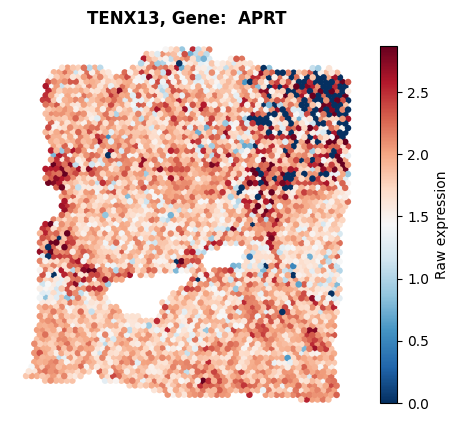

In [ ]:
gene_name = "APRT"

plot_gt_raw_spatial_gene(
    coords=coords,
    gene_exp_top=gene_exp_top,
    gene_names_top=gene_names_top,
    gene=gene_name,
    wsi_path=None,          
    spot_size=22,           
    figsize=(5, 5),
    title="TENX13, Gene:  " + gene_name,
    cmap="RdBu_r",
    clip_quantiles=(1, 99)  
)

## ViT (no mixup)

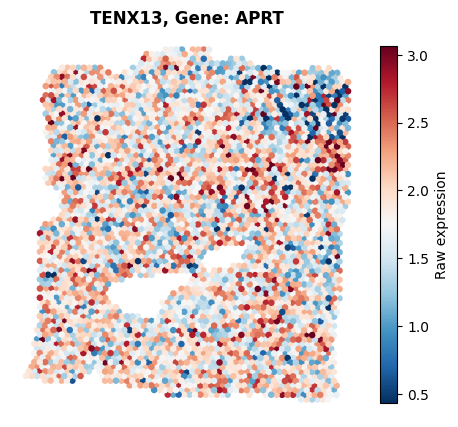

In [ ]:
nomixup_pred = pd.read_csv("/home/hongyi/project/Pred_Results/TENX13/TENX13_raw_pred.csv", index_col=0).values
plot_gt_raw_spatial_gene(
    coords=coords,
    gene_exp_top=nomixup_pred,
    gene_names_top=gene_names_top,
    gene=gene_name,
    wsi_path=None,          
    spot_size=22,           
    figsize=(5, 5),
    title="TENX13, Gene: " + gene_name,
    cmap="RdBu_r",
    clip_quantiles=(1, 99)  
)

## Basic Augmentation

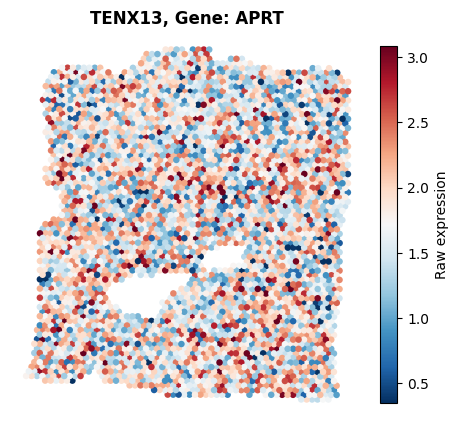

In [ ]:
basic_pred = pd.read_csv("/home/hongyi/project/Pred_Results/TENX13/TENX13_basic_pred.csv", index_col=0).values
plot_gt_raw_spatial_gene(
    coords=coords,
    gene_exp_top=basic_pred,
    gene_names_top=gene_names_top,
    gene=gene_name,
    wsi_path=None,          
    spot_size=22,           
    figsize=(5, 5),
    title="TENX13, Gene: " + gene_name,
    cmap="RdBu_r",
    clip_quantiles=(1, 99)  
)

## Mixup

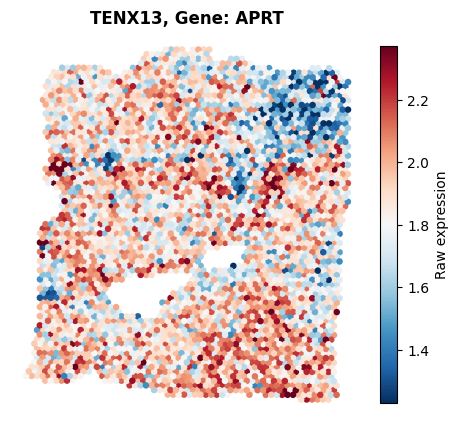

In [ ]:
mixup_pred = pd.read_csv("/home/hongyi/project/Pred_Results/TENX13/TENX13_mixup_pred.csv", index_col=0).values
plot_gt_raw_spatial_gene(
    coords=coords,
    gene_exp_top=mixup_pred,
    gene_names_top=gene_names_top,
    gene=gene_name,
    wsi_path=None,          
    spot_size=22,           
    figsize=(5, 5),
    title="TENX13, Gene: " + gene_name,
    cmap="RdBu_r",
    clip_quantiles=(1, 99)  
)

## CutMix

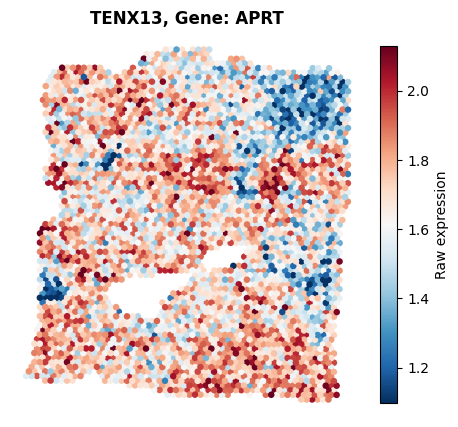

In [ ]:
cutmix_pred = pd.read_csv("/home/hongyi/project/Pred_Results/TENX13/TENX13_cutmix_pred.csv", index_col=0).values
plot_gt_raw_spatial_gene(
    coords=coords,
    gene_exp_top=cutmix_pred,
    gene_names_top=gene_names_top,
    gene=gene_name,
    wsi_path=None,          
    spot_size=22,           
    figsize=(5, 5),
    title="TENX13, Gene: " + gene_name,
    cmap="RdBu_r",
    clip_quantiles=(1, 99)  
)

## SNR-ST-Mix

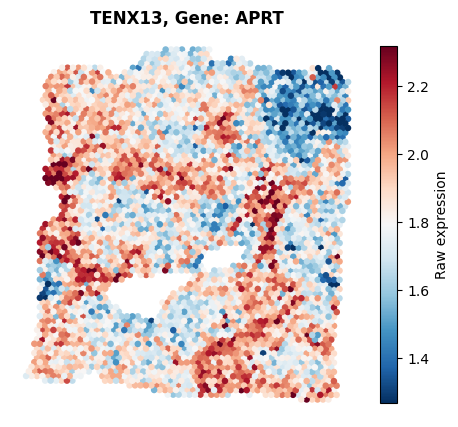

In [ ]:
SNR_pred = pd.read_csv("/home/hongyi/project/Pred_Results/TENX13/TENX13_SNR_pred.csv", index_col=0).values
plot_gt_raw_spatial_gene(
    coords=coords,
    gene_exp_top=SNR_pred,
    gene_names_top=gene_names_top,
    gene=gene_name,
    wsi_path=None,          
    spot_size=22,           
    figsize=(5, 5),
    title="TENX13, Gene: " + gene_name,
    cmap="RdBu_r",
    clip_quantiles=(1, 99)  
)

## Comparison among methods

In [ ]:
def panel_compare_methods_with_cbar(
    coords: np.ndarray,                    # (N,2)
    gene_exp_top: np.ndarray,              # GT, (N,G)
    gene_names_top: Sequence[str],
    preds: Dict[str, np.ndarray],          
    genes: Sequence[int|str],              # list of gene indices or symbols
    *,
    methods_order: Sequence[str] = ("no mixup","basic","mixup","cutmix","SNR-ST-Mix"),
    clip_quantiles: Tuple[float,float]=(1,99),
    cmap: str = "Blue",
    spot_size: int = 10,
    invert_y: bool = True,
    figsize_cell: Tuple[float,float] = (3.0, 3.0),
    dpi: int = 300,
    outpath: str | None = None
):
    """
    Create a panel comparing different prediction methods for gene expression.
    Shows raw expression, shared scale per row, MSE under each method cell.
    Keeps a colorbar per row on the right.
    """
    # keep only methods that exist in preds (in given order)
    methods = [m for m in methods_order if m in preds]
    col_labels = methods + ["Ground Truth"]

    R, C = len(genes), len(col_labels)
    cell_w, cell_h = 3.0, 3.0
    extra_w, extra_h = 0.8, 0.6
    fig, axes = plt.subplots(
        R, C,
        figsize=(C * cell_w + extra_w, R * cell_h + extra_h),
        dpi=dpi
    )
    #fig, axes = plt.subplots(R, C, figsize=(fig_w, fig_h), dpi=dpi)
    if R == 1: axes = np.expand_dims(axes, 0)
    if C == 1: axes = np.expand_dims(axes, 1)

    last_im = None
    for r, g in enumerate(genes):
        gi = _ensure_gene_index(gene_names_top, g)
        gene_label = str(gene_names_top[gi])

        # shared scale from GT + all selected methods (raw values)
        arrays = [gene_exp_top[:, gi]] + [preds[m][:, gi] for m in methods]
        vmin, vmax = _robust_limits(arrays, q=clip_quantiles)

        for c, label in enumerate(col_labels):
            ax = axes[r, c]
            if label == "Ground Truth":
                vals = gene_exp_top[:, gi].astype(float)
                mse_txt = "MSE 0"
            else:
                vals = preds[label][:, gi].astype(float)
                diff = vals - gene_exp_top[:, gi]
                mse = float((diff**2).mean())
                mse_txt = f"MSE {mse:.3f}"

            # scatter “paper dots” look
            last_im = ax.scatter(
                coords[:,0], coords[:,1],
                c=vals, s=spot_size, cmap=cmap,
                vmin=vmin, vmax=vmax, edgecolors="none", 
                alpha=0.9, linewidths=0, 
                rasterized=True
            )
            # aesthetics
            ax.set_xticks([]); ax.set_yticks([]); ax.set_frame_on(False)
            if invert_y: ax.invert_yaxis()
            ax.set_aspect("equal", adjustable="box")

            # row label (gene) on leftmost cell
            if c == 0:
                ax.text(-0.06, 0.5, gene_label, transform=ax.transAxes,
                        rotation=90, va="center", ha="right", fontsize=14, weight="bold")

            # column labels on bottom row
            if r == R - 1:
                ax.set_title(label, fontsize=14, pad=6, weight="bold")

            # MSE under each subplot
            ax.text(0.5, -0.10, mse_txt, transform=ax.transAxes,
                    ha="center", va="top", fontsize=14, weight="bold")
            

        # add a colorbar for this row 
        # derive position from the rightmost cell in the row
        right_ax = axes[r, -1]
        bbox = right_ax.get_position()
        cax = fig.add_axes([bbox.x1 + 0.03, bbox.y0, 0.015, bbox.height])
        cb = fig.colorbar(last_im, cax=cax)
        cb.set_label("Expression", fontsize=10)

    #fig.suptitle(f"TENX13: Visualization of the Predicted Expression for Selected Genes", fontsize=16, fontweight="bold", y=1.02)
    plt.tight_layout(w_pad=0.4, h_pad=0.6, rect=(0.02, 0.02, 0.92, 0.96))
    if outpath:
        os.makedirs(os.path.dirname(outpath), exist_ok=True)
        fig.savefig(outpath, dpi=dpi, bbox_inches="tight")
    plt.show()

/tmp/ipykernel_243655/2173850214.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=0.4, h_pad=0.6, rect=(0.02, 0.02, 0.92, 0.96))


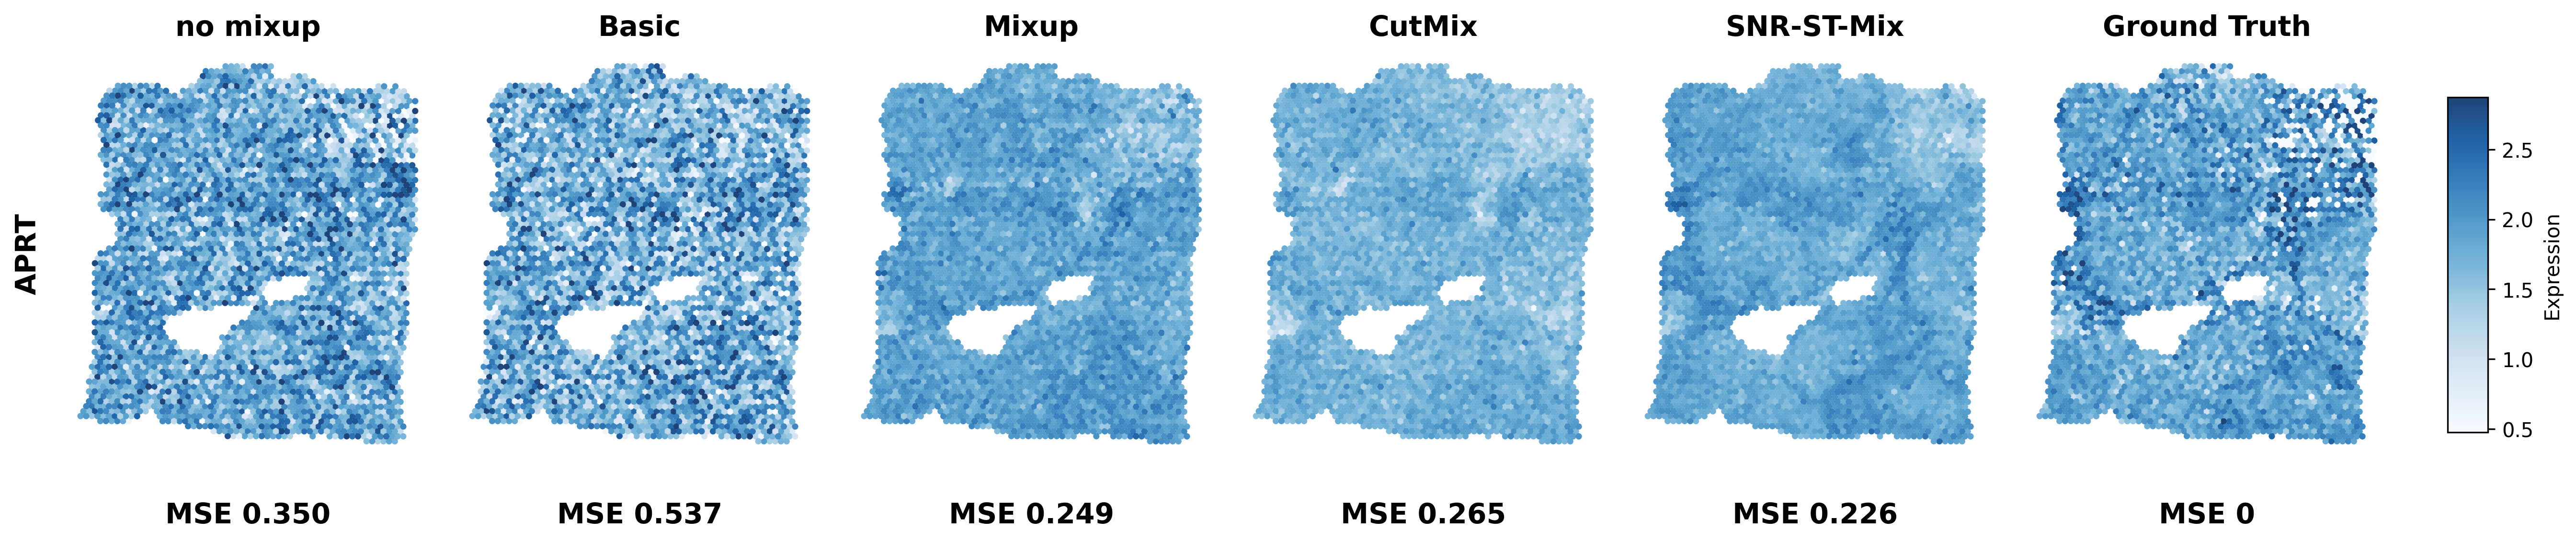

In [12]:
preds = {
    "no mixup": nomixup_pred,   # (N, G)
    "Basic":    basic_pred,
    "Mixup":    mixup_pred,
    "CutMix":   cutmix_pred,
    "SNR-ST-Mix":      SNR_pred,        
}

genes_to_show = ["APRT"]  # or indices
panel_compare_methods_with_cbar(
    coords=coords,
    gene_exp_top=gene_exp_top,
    gene_names_top=gene_names_top,
    preds=preds,
    genes=genes_to_show,
    methods_order=("no mixup","Basic","Mixup","CutMix","SNR-ST-Mix"),
    clip_quantiles=(1, 99),
    cmap="Blues",
    spot_size=10
)

In [15]:
def panel_error_methods(
    coords: np.ndarray,
    Y_true: np.ndarray,
    gene_names_top: Sequence[str],
    preds: Dict[str, np.ndarray],
    genes: Sequence[str|int],
    *,
    methods_order: Sequence[str] = ("no mixup","Basic","Mixup","CutMix","SNR-ST-Mix"),
    q_hi: float = 99.0,
    cmap_signed: str = "RdBu_r",
    spot_size: int = 10,
    train_idx: Optional[np.ndarray] = None,
    test_idx: Optional[np.ndarray] = None,
    figsize_cell: Tuple[float,float] = (3.0, 3.0),
    dpi: int = 300,
    pad_to_ncols: Optional[int] = None,   # ensures same #cols as top panel
    outpath: Optional[str] = None
):
    import matplotlib.pyplot as plt
    from matplotlib.colors import TwoSlopeNorm

    # Match font sizes to panel_compare_methods_with_cbar
    FONT_TITLE = 14
    FONT_GENE  = 14
    FONT_MSE   = 14
    FONT_CBAR  = 10

    methods = [m for m in methods_order if m in preds]
    R, C0 = len(genes), len(methods)
    C = max(C0, pad_to_ncols or C0)   # pad columns to align with first row

    # Same cell scaling
    fig_w = C * figsize_cell[0] + 0.6
    fig_h = R * figsize_cell[1] + 0.6
    fig, axes = plt.subplots(R, C, figsize=(fig_w, fig_h), dpi=dpi)
    if R == 1: axes = np.expand_dims(axes, 0)
    if C == 1: axes = np.expand_dims(axes, 1)

    for r, g in enumerate(genes):
        gi = _ensure_gene_index(gene_names_top, g)
        gt = Y_true[:, gi].astype(float)

        # Compute symmetric color range for error
        errs_all = []
        for m in methods:
            pr = preds[m][:, gi].astype(float)
            e = pr - gt
            idx = test_idx if test_idx is not None else np.arange(len(e))
            errs_all.append(e[idx])
        vmax = float(np.percentile(np.abs(np.concatenate(errs_all)), q_hi))
        norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)

        last_im = None
        for c, m in enumerate(methods):
            ax = axes[r, c]
            pr = preds[m][:, gi].astype(float)
            e = pr - gt
            mse = float(((pr - gt)**2).mean())

            # gray training spots
            if train_idx is not None and test_idx is not None:
                ax.scatter(coords[train_idx,0], coords[train_idx,1],
                           s=spot_size, c="lightgray", edgecolors="none", alpha=0.6, zorder=1)
                idx = test_idx
            else:
                idx = np.arange(coords.shape[0])

            # signed error scatter
            last_im = ax.scatter(
                coords[idx,0], coords[idx,1],
                c=e[idx], s=spot_size, cmap=cmap_signed, norm=norm,
                edgecolors="none", rasterized=True
            )

            ax.set_xticks([]); ax.set_yticks([]); ax.set_frame_on(False)
            ax.set_aspect("equal"); ax.invert_yaxis()

            if r == 0:
                ax.set_title(m, fontsize=FONT_TITLE, pad=6, weight="bold")
            if c == 0:
                ax.text(-0.06, 0.5, str(gene_names_top[gi]), transform=ax.transAxes,
                        rotation=90, va="center", ha="right",
                        fontsize=FONT_GENE, weight="bold")
            ax.text(0.5, -0.10, f"MSE {mse:.3f}", transform=ax.transAxes,
                    ha="center", va="top", fontsize=FONT_MSE, weight="bold")

        # hide padded (empty) axes to preserve cell size
        for c in range(C0, C):
            axes[r, c].axis("off")

        # aligned colorbar
        right_ax = axes[r, -1]
        bbox = right_ax.get_position()
        cax = fig.add_axes([bbox.x1 + 0.03, bbox.y0, 0.015, bbox.height])
        cb  = fig.colorbar(last_im, cax=cax)
        cb.set_label("Error (Pred − GT)", fontsize=FONT_CBAR)
        cb.ax.tick_params(labelsize=FONT_CBAR - 1)

    plt.tight_layout(w_pad=0.4, h_pad=0.6, rect=(0.02, 0.02, 0.92, 0.96))
    if outpath:
        os.makedirs(os.path.dirname(outpath), exist_ok=True)
        fig.savefig(outpath, bbox_inches="tight", dpi=dpi)
    plt.show()



/tmp/ipykernel_243655/3183790063.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=0.4, h_pad=0.6, rect=(0.02, 0.02, 0.92, 0.96))


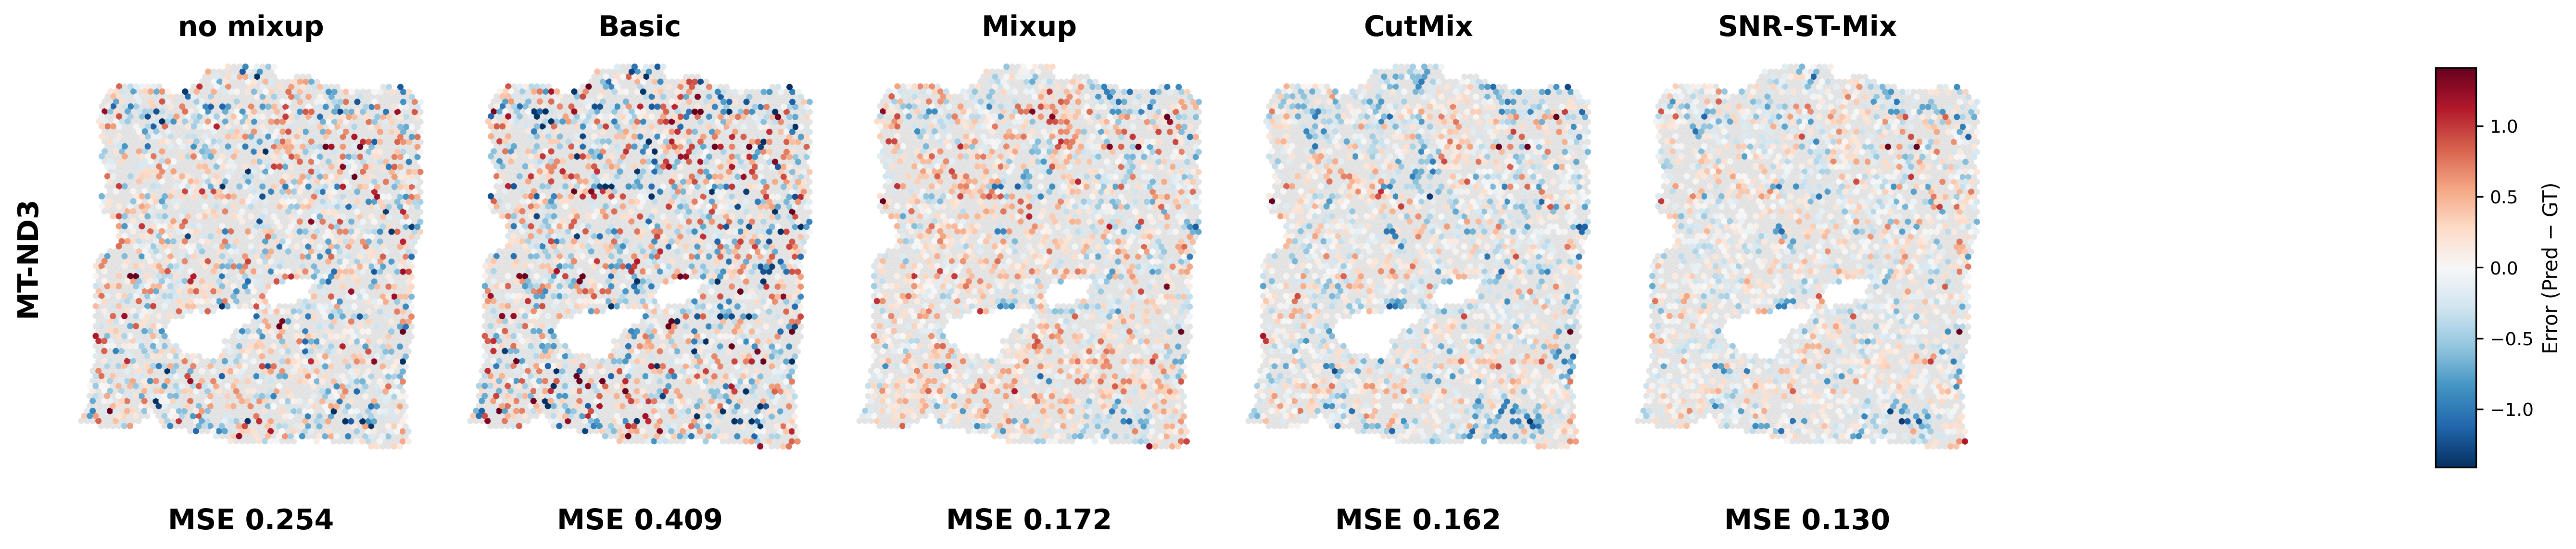

In [16]:
panel_error_methods(coords, gene_exp_top, gene_names_top, preds,
                    genes=["MT-ND3"],
                    train_idx=train_idx, test_idx=test_idx,
                    pad_to_ncols=6, figsize_cell=(3.0,3.0), dpi=300)